In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso


------------------------------------------
✅ Runtime: 1.9 ms | 💾 Mem: 168.91 MB (Δ +0.39 MB) | ⚙️ CPU: 35.9%


In [6]:
REGION = "Gyeonggi"
CITY = "Seongnam"


------------------------------------------
✅ Runtime: 1.3 ms | 💾 Mem: 245.61 MB (Δ +0.44 MB) | ⚙️ CPU: 38.6%


In [19]:
co2_df = pd.read_csv("./data/co2/korean_cities_environmental_data_fake.csv")
co2_df['datetime'] = pd.to_datetime(co2_df['datetime'])
# co2_df = co2_df[(co2_df['region']== REGION) & (co2_df['city'] == CITY)]
co2_df

,datetime,region,city,electricity_usage_kwh,traffic_volume_vehicles,industrial_output_units,temperature_celsius,humidity_percent,public_transport_passengers,population_density_per_km2,co2_emissions_ppm
0,2025-11-08 18:58:35.040324,Busan,Busanjin-gu,4971.98,1075.0,1087.85,12.86,68.7,932.0,915.0,453.41
1,2025-11-08 18:58:35.040324,Busan,Gangseo-gu,6252.59,1780.0,2851.46,9.53,69.0,2196.0,2603.0,478.55
2,2025-11-08 18:58:35.040324,Busan,Haeundae-gu,9007.39,22566.0,976.28,11.56,68.9,26638.0,8427.0,547.03
3,2025-11-08 18:58:35.040324,Busan,Saha-gu,9259.80,3322.0,1191.44,8.34,60.0,459.0,116.0,527.42
4,2025-11-08 18:58:35.040324,Busan,Suyeong-gu,2741.12,628.0,551.91,9.18,72.5,1151.0,357.0,489.98
...,...,...,...,...,...,...,...,...,...,...,...
5835,2025-11-11 18:58:35.040324,Ulsan,Buk-gu,7963.19,5104.0,4319.10,8.16,72.8,3812.0,2644.0,525.85
5836,2025-11-11 18:58:35.040324,Ulsan,Dong-gu,7653.56,3724.0,908.54,11.81,55.9,2506.0,2815.0,543.28
5837,2025-11-11 18:58:35.040324,Ulsan,Jung-gu,26453.34,11577.0,2804.36,10.72,67.5,30834.0,13073.0,551.38
5838,2025-11-11 18:58:35.040324,Ulsan,Nam-gu,10561.30,2362.0,2053.55,9.58,59.0,2616.0,2894.0,562.73



------------------------------------------
✅ Runtime: 41.6 ms | 💾 Mem: 353.97 MB (Δ -20.66 MB) | ⚙️ CPU: 22.0%


R² score on test set: 0.20333254999085526


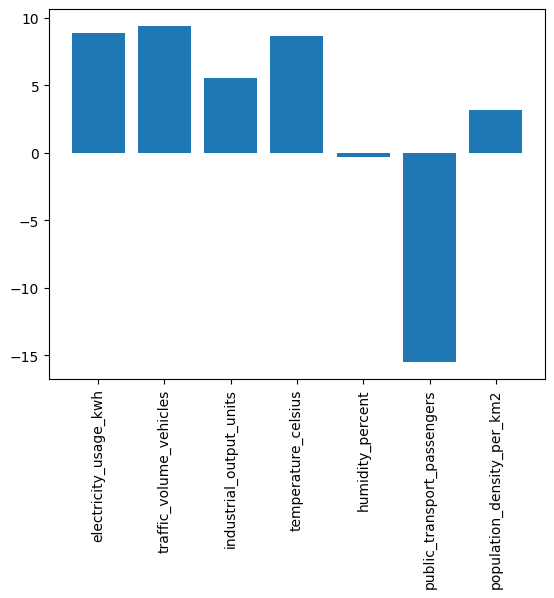


------------------------------------------
✅ Runtime: 74.4 ms | 💾 Mem: 193.17 MB (Δ +4.31 MB) | ⚙️ CPU: 14.0%


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

x_series = co2_df.drop(['co2_emissions_ppm', 'datetime', 'region', 'city'], axis=1)
# Split features and target
X = x_series.values
y = co2_df['co2_emissions_ppm'].values  # no need for reshape here

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Define and train Lasso model
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)

# Evaluate model
score = lasso_reg.score(X_test, y_test)
print("R² score on test set:", score)

lasso_coef = lasso_reg.coef_
plt.bar(x_series.columns, lasso_coef)
plt.xticks(rotation=90)
plt.show()


In [28]:
from sklearn.preprocessing import StandardScaler

def analyze_co2_causes(co2_df):
    """
    Analyze and identify the most important causes of CO2 emissions
    """
    
    # Prepare features (dropping non-numeric and target columns)
    x_series = co2_df.drop(['co2_emissions_ppm', 'datetime', 'region', 'city'], axis=1)
    
    # Get feature names
    feature_names = x_series.columns.tolist()
    
    # Split features and target
    X = x_series.values
    y = co2_df['co2_emissions_ppm'].values
    
    # Standardize features for better Lasso performance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42
    )
    
    # Define and train Lasso model
    lasso_reg = Lasso(alpha=0.1)
    lasso_reg.fit(X_train, y_train)
    
    # Evaluate model
    train_score = lasso_reg.score(X_train, y_train)
    test_score = lasso_reg.score(X_test, y_test)
    
    print("=" * 60)
    print("MODEL PERFORMANCE")
    print("=" * 60)
    print(f"R² score on training set: {train_score:.4f}")
    print(f"R² score on test set: {test_score:.4f}")
    print()
    
    # Get coefficients
    lasso_coef = lasso_reg.coef_
    
    # Create a DataFrame for better analysis
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': lasso_coef,
        'Abs_Coefficient': np.abs(lasso_coef)
    })
    
    # Sort by absolute coefficient value
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Identify non-zero coefficients (features selected by Lasso)
    selected_features = coef_df[coef_df['Coefficient'] != 0]
    removed_features = coef_df[coef_df['Coefficient'] == 0]
    
    print("=" * 60)
    print("MOST IMPORTANT CAUSES (Ranked by Impact)")
    print("=" * 60)
    print(f"\nTotal features analyzed: {len(feature_names)}")
    print(f"Features selected by Lasso: {len(selected_features)}")
    print(f"Features removed (zero coefficient): {len(removed_features)}")
    print()
    
    if len(selected_features) > 0:
        print("TOP CONTRIBUTING FACTORS:")
        print("-" * 60)
        for idx, row in selected_features.iterrows():
            impact = "POSITIVE" if row['Coefficient'] > 0 else "NEGATIVE"
            print(f"{row['Feature']:25s} | Coef: {row['Coefficient']:8.4f} | {impact}")
    
    if len(removed_features) > 0:
        print("\n" + "=" * 60)
        print("FEATURES WITH NO IMPACT (Removed by Lasso):")
        print("-" * 60)
        for feature in removed_features['Feature'].values:
            print(f"  - {feature}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: All coefficients
    ax1 = axes[0]
    colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient']]
    ax1.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
    ax1.set_xlabel('Lasso Coefficient', fontsize=12)
    ax1.set_title('Feature Importance for CO2 Emissions (All Features)', fontsize=14, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Only non-zero coefficients
    ax2 = axes[1]
    if len(selected_features) > 0:
        colors_selected = ['red' if c < 0 else 'green' for c in selected_features['Coefficient']]
        ax2.barh(selected_features['Feature'], selected_features['Coefficient'], 
                 color=colors_selected, alpha=0.7)
        ax2.set_xlabel('Lasso Coefficient', fontsize=12)
        ax2.set_title('Most Important Causes (Non-Zero Coefficients Only)', fontsize=14, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax2.grid(axis='x', alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No features selected by Lasso', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    print("\n" + "=" * 60)
    print("Visualization saved to: co2_feature_importance.png")
    print("=" * 60)
    
    return coef_df, lasso_reg, test_score


------------------------------------------
✅ Runtime: 3.1 ms | 💾 Mem: 167.47 MB (Δ -1.44 MB) | ⚙️ CPU: 32.6%


MODEL PERFORMANCE
R² score on training set: 0.2122
R² score on test set: 0.2033

MOST IMPORTANT CAUSES (Ranked by Impact)

Total features analyzed: 7
Features selected by Lasso: 7
Features removed (zero coefficient): 0

TOP CONTRIBUTING FACTORS:
------------------------------------------------------------
public_transport_passengers | Coef: -15.4938 | NEGATIVE
traffic_volume_vehicles   | Coef:   9.3833 | POSITIVE
electricity_usage_kwh     | Coef:   8.8510 | POSITIVE
temperature_celsius       | Coef:   8.6100 | POSITIVE
industrial_output_units   | Coef:   5.5373 | POSITIVE
population_density_per_km2 | Coef:   3.1865 | POSITIVE
humidity_percent          | Coef:  -0.3128 | NEGATIVE


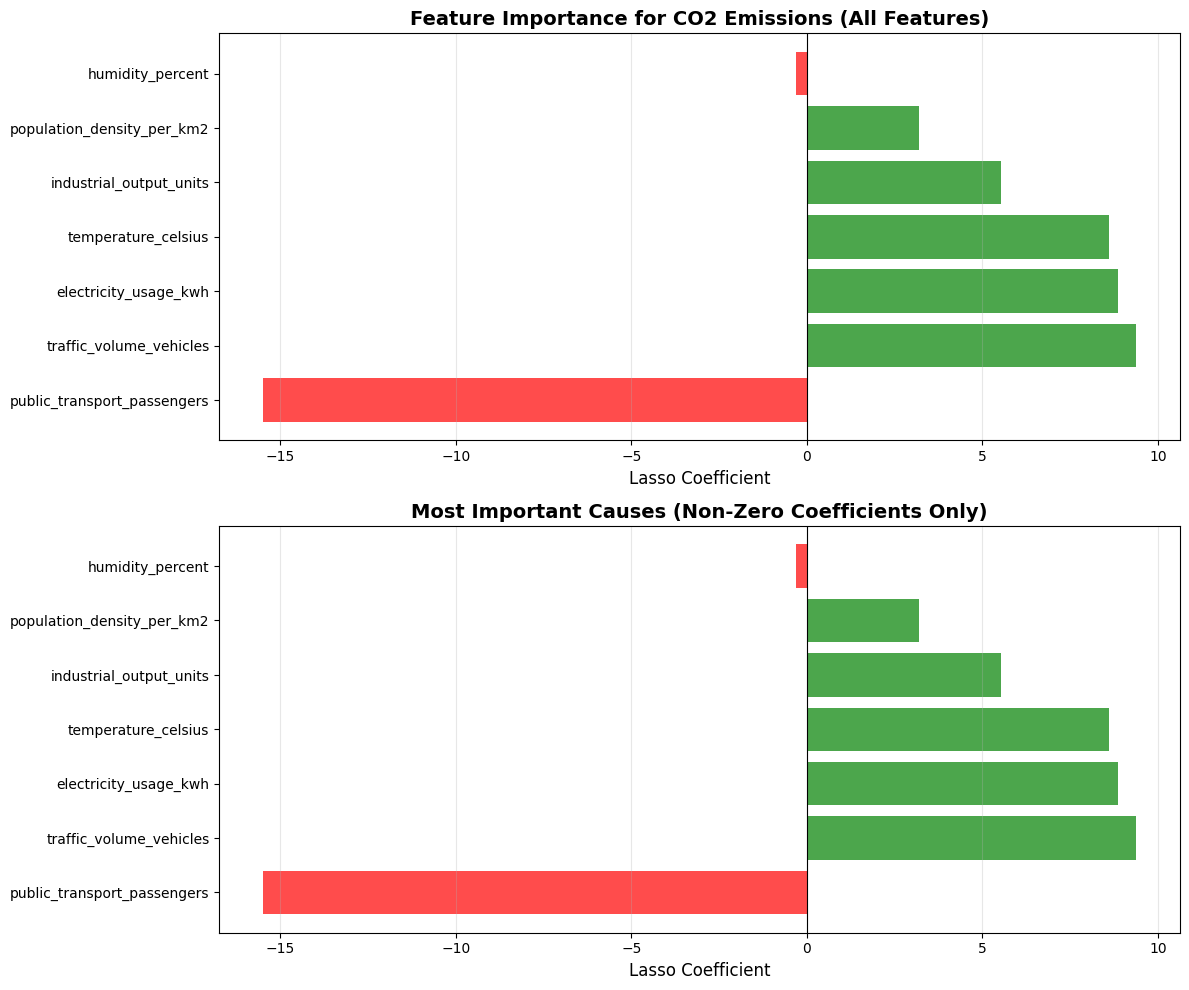


Visualization saved to: co2_feature_importance.png


(                       Feature  Coefficient  Abs_Coefficient
 5  public_transport_passengers   -15.493780        15.493780
 1      traffic_volume_vehicles     9.383304         9.383304
 0        electricity_usage_kwh     8.851014         8.851014
 3          temperature_celsius     8.610027         8.610027
 2      industrial_output_units     5.537288         5.537288
 6   population_density_per_km2     3.186479         3.186479
 4             humidity_percent    -0.312809         0.312809,
 Lasso(alpha=0.1),
 0.20333254999085526)


------------------------------------------
✅ Runtime: 154.4 ms | 💾 Mem: 191.92 MB (Δ +24.45 MB) | ⚙️ CPU: 20.9%


In [29]:
analyze_co2_causes(co2_df)